In [1]:
import numpy as np
import torch
from torch import nn
import torchaudio
import os
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import math
import timm
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, f1_score, classification_report, ConfusionMatrixDisplay

In [2]:
train_audio_files_path = '/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_train/flac'
train_labels_path = '/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt'
len(os.listdir(train_audio_files_path))

25380

In [3]:
def readtxtfile(path):
    with open(path, 'r') as file:
        text = file.read().splitlines()
        return text
    
def getlabels(path):
    text = readtxtfile(path)
    filename2label = {}
    for item in tqdm(text):
        key = item.split(' ')[1]
        value = item.split(' ')[-1]
        filename2label[key] = value
        
    return filename2label

In [4]:
filename2label = getlabels(train_labels_path)

  0%|          | 0/25380 [00:00<?, ?it/s]

In [5]:
val_audio_files_path = '/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_dev/flac'
val_labels_path = '/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.dev.trl.txt'
val_filename2label = getlabels(val_labels_path)

  0%|          | 0/24844 [00:00<?, ?it/s]

2580 22800


(array([ 2580.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 22800.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

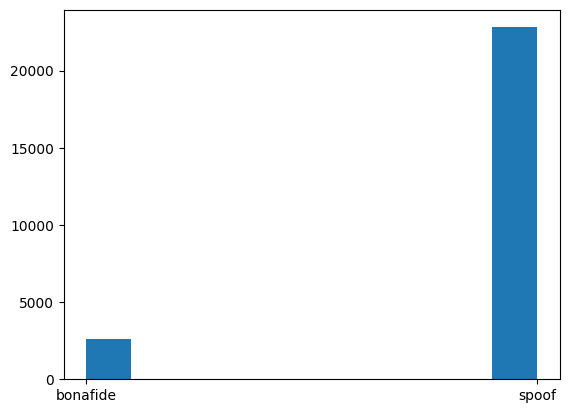

In [6]:
l = list(filename2label.values())
print(l.count('bonafide'), l.count('spoof'))
plt.hist(l)

In [7]:
## for denoising function select any wavelet transform 
import pywt
print("The mother function you can use")


print(pywt.wavelist())

The mother function you can use
['bior1.1', 'bior1.3', 'bior1.5', 'bior2.2', 'bior2.4', 'bior2.6', 'bior2.8', 'bior3.1', 'bior3.3', 'bior3.5', 'bior3.7', 'bior3.9', 'bior4.4', 'bior5.5', 'bior6.8', 'cgau1', 'cgau2', 'cgau3', 'cgau4', 'cgau5', 'cgau6', 'cgau7', 'cgau8', 'cmor', 'coif1', 'coif2', 'coif3', 'coif4', 'coif5', 'coif6', 'coif7', 'coif8', 'coif9', 'coif10', 'coif11', 'coif12', 'coif13', 'coif14', 'coif15', 'coif16', 'coif17', 'db1', 'db2', 'db3', 'db4', 'db5', 'db6', 'db7', 'db8', 'db9', 'db10', 'db11', 'db12', 'db13', 'db14', 'db15', 'db16', 'db17', 'db18', 'db19', 'db20', 'db21', 'db22', 'db23', 'db24', 'db25', 'db26', 'db27', 'db28', 'db29', 'db30', 'db31', 'db32', 'db33', 'db34', 'db35', 'db36', 'db37', 'db38', 'dmey', 'fbsp', 'gaus1', 'gaus2', 'gaus3', 'gaus4', 'gaus5', 'gaus6', 'gaus7', 'gaus8', 'haar', 'mexh', 'morl', 'rbio1.1', 'rbio1.3', 'rbio1.5', 'rbio2.2', 'rbio2.4', 'rbio2.6', 'rbio2.8', 'rbio3.1', 'rbio3.3', 'rbio3.5', 'rbio3.7', 'rbio3.9', 'rbio4.4', 'rbio5.5', 

In [8]:
import numpy as np
import pywt

def denoise(signal, wavelet='haar', level=1):
    # Convert the signal tensor to numpy array
    signal_np = signal.numpy()
    
    # Apply wavelet denoising
    coeff = pywt.wavedec(signal_np, wavelet, mode="per")
    sigma = (1/0.6745) * maddest(coeff[-level])
    uthresh = sigma * np.sqrt(2*np.log(len(signal_np)))
    coeff[1:] = [pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:]]
    denoised_signal = pywt.waverec(coeff, wavelet, mode='per')
    
    # Convert the denoised signal back to tensor
    denoised_signal = torch.tensor(denoised_signal)
    
    return denoised_signal

# Function to calculate Median Absolute Deviation (MAD)
def maddest(d, axis=None):
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)


In [9]:
import numpy as np
import torch
from scipy.signal import butter, lfilter

def butter_lowpass_filter(data, cutoff_freq: int = 20, sampling_rate: int = 200, order: int = 4):
    # Convert tensor to numpy array
    data_np = data.numpy()
    
    nyquist = 0.5 * sampling_rate
    normal_cutoff = cutoff_freq / nyquist
    
    # Design the filter
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    
    # Apply the filter
    filtered_data_np = lfilter(b, a, data_np, axis=0)
    
    # Convert back to tensor
    filtered_data = torch.tensor(filtered_data_np, dtype=data.dtype)
    
    return filtered_data


In [10]:
class ASVSpoof(torch.utils.data.Dataset):
    def __init__(self, audio_dir_path, num_samples, filename2label,transforms, transforms0 ):   
        super().__init__()
        self.audio_dir_path = audio_dir_path
        self.num_samples = num_samples
        self.audio_file_names = self.get_audio_file_names(filename2label)
        self.labels, self.label2id, self.id2label = self.get_labels(filename2label)
        self.transforms = transforms
        self.transforms0 = transforms0
#         self.transforms1 = transforms1
        
    def __getitem__(self, index):
        signal, sr = torchaudio.load(os.path.join(self.audio_dir_path, self.audio_file_names[index]))
#         print(signal.shape)
        signal = self.mix_down_if_necessary(signal)
        signal = self.cut_if_necessary(signal)
#         print(signal.shape)
        signal = self.right_pad_if_necessary(signal)
#         print(signal.shape)
        signal = self.transforms(signal)
#         print(signal.shape)
        signal = self.transforms0(signal)
        signal = signal[:,32768:65536]
#         print(signal.shape)
#         signal = self.transforms1(signal)
#         print(signal.shape)
        label = (self.labels[index])
        return signal, label
    
    def __len__(self):
        return len(self.labels)
    
    def get_audio_file_names(self, filename2label):
        audio_file_names = list(filename2label.keys())
        audio_file_names = [name + '.flac' for name in audio_file_names] # adding extension
        return audio_file_names
    
    def get_labels(self, filename2label):
        labels = list(filename2label.values())
        id2label = {idx : label for idx, label in  enumerate(list(set(labels)))}
        label2id = {label : idx for idx, label in  enumerate(list(set(labels)))}
        labels = [label2id[label] for label in labels]
        return labels, label2id, id2label
    
    def mix_down_if_necessary(self, signal): #converting from stereo to mono
        if signal.shape[0] > 1: 
            signal = torch.mean(signal, dim = 0, keepdims = True)
        return signal
    
    def cut_if_necessary(self, signal):
        if signal.shape[1] > self.num_samples:
            signal = signal[:, :num_samples]
        return signal
    
    def right_pad_if_necessary(self, signal):
        length = signal.shape[1]
        if self.num_samples > length:
            pad_last_dim = (0, num_samples - length)
            signal = torch.nn.functional.pad(signal, pad_last_dim)
        return signal

In [11]:
# mel_spectogram = torchaudio.transforms.MelSpectrogram(
#     sample_rate = 16000,
#     n_fft = 1024,
#     hop_length = 512,
#     n_mels = 64
# )
num_samples = 6 * 16000 # IMPORTANT!!
train_dataset = ASVSpoof(train_audio_files_path, num_samples, filename2label,denoise,butter_lowpass_filter)       #denoise,butter_lowpass_filter,
val_dataset = ASVSpoof(val_audio_files_path, num_samples, val_filename2label,denoise,butter_lowpass_filter)

In [12]:
sample,label = train_dataset[0]
print(sample.shape)

torch.Size([1, 32768])


In [13]:
# import matplotlib.pyplot as plt

# # Assuming 'sample' is your Mel spectrogram tensor with shape [1, 64, 188]
# sample,label = train_dataset[1010]
# print(sample.shape)
# # Convert the tensor to a NumPy array and squeeze to remove the singleton dimension


# # Plot the Mel spectrogram
# plt.figure(figsize=(10, 4))
# plt.imshow(mel_spectrogram, cmap='viridis', origin='lower', aspect='auto')
# plt.title("Mel Spectrogram")
# plt.xlabel("Time Frames")
# plt.ylabel("Mel Frequency Bins")
# plt.colorbar(label="Intensity (dB)")
# plt.show()

In [14]:
class Wave_Block(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, dilation_rates: int, kernel_size: int = 3):
        """
        WaveNet building block.
        :param in_channels: number of input channels.
        :param out_channels: number of output channels.
        :param dilation_rates: how many levels of dilations are used.
        :param kernel_size: size of the convolving kernel.
        """
        super(Wave_Block, self).__init__()
        self.num_rates = dilation_rates
        self.convs = nn.ModuleList()
        self.filter_convs = nn.ModuleList()
        self.gate_convs = nn.ModuleList()
        self.convs.append(nn.Conv1d(in_channels, out_channels, kernel_size=1, bias=True))
        
        dilation_rates = [2 ** i for i in range(dilation_rates)]
        for dilation_rate in dilation_rates:
            self.filter_convs.append(
                nn.Conv1d(out_channels, out_channels, kernel_size=kernel_size,
                          padding=int((dilation_rate*(kernel_size-1))/2), dilation=dilation_rate))
            self.gate_convs.append(
                nn.Conv1d(out_channels, out_channels, kernel_size=kernel_size,
                          padding=int((dilation_rate*(kernel_size-1))/2), dilation=dilation_rate))
            self.convs.append(nn.Conv1d(out_channels, out_channels, kernel_size=1, bias=True))
        
        for i in range(len(self.convs)):
            nn.init.xavier_uniform_(self.convs[i].weight, gain=nn.init.calculate_gain('relu'))
            nn.init.zeros_(self.convs[i].bias)

        for i in range(len(self.filter_convs)):
            nn.init.xavier_uniform_(self.filter_convs[i].weight, gain=nn.init.calculate_gain('relu'))
            nn.init.zeros_(self.filter_convs[i].bias)

        for i in range(len(self.gate_convs)):
            nn.init.xavier_uniform_(self.gate_convs[i].weight, gain=nn.init.calculate_gain('relu'))
            nn.init.zeros_(self.gate_convs[i].bias)

    def forward(self, x):
        x = self.convs[0](x)
        res = x
        for i in range(self.num_rates):
            tanh_out = torch.tanh(self.filter_convs[i](x))
            sigmoid_out = torch.sigmoid(self.gate_convs[i](x))
            x = tanh_out * sigmoid_out
            x = self.convs[i + 1](x) 
#             print(x.shape)
            res = res + x
        return res
    
class WaveNet(nn.Module):
    def __init__(self, input_channels: int = 1, kernel_size: int = 3):
        super(WaveNet, self).__init__()
        self.model = nn.Sequential(
                Wave_Block(input_channels, 8, 12, kernel_size),
                Wave_Block(8, 16, 8, kernel_size),
                Wave_Block(16, 32, 4, kernel_size),
                Wave_Block(32, 64, 1, kernel_size) 
        )
    def forward(self, x: torch.Tensor) -> torch.Tensor:
#         print(x.shape)
#         x = x.permute(0, 2, 1) 
        output = self.model(x)
#         print(output.shape)
        return output


class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.model = WaveNet()
        self.global_avg_pooling = nn.AdaptiveAvgPool1d(1)
        self.dropout = 0.0
        self.head = nn.Sequential(
            nn.Linear(64,8),
            nn.BatchNorm1d(8),
            nn.ReLU(),
            nn.Dropout(self.dropout),
            nn.Linear(8,4),
            nn.Linear(4,1),
            nn.Sigmoid()
            )
        
    def forward(self, x: torch.Tensor):

        x = self.model(x)
#         x = x.permute(0,2,1)   ##because the global_averaging  acts on dim = 2 we want to average out all the channels to feed in the classifier since the classifier contains linear layers 
        print(f"before GAP {x.shape}")
        x = self.global_avg_pooling(x)
#         x = x.permute(0,2,1)
        print(x.shape)
        x = x.squeeze()
        x = self.head(x)
#         x=x.squeeze(dim=1)
        return x
model3 = Model()
total_params = sum(p.numel() for p in model3.parameters() if p.requires_grad)
print(f"Total number of parameters: {total_params}")


Total number of parameters: 81697


In [20]:
 class Model2(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = timm.create_model('resnet101', pretrained=True, in_chans=1)
        for i, (name, param) in enumerate(list(self.model.named_parameters())[:39]):
            param.requires_grad = False
            
        self.features = nn.Sequential(*list(self.model.children())[:-2])
        
        self.custom_layers = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(self.model.num_features, 1),
            nn.Sigmoid()
        )
        
    def forward(self, inputs):
        x = self.features(inputs)
        x = self.custom_layers(x)
        return x

    def print_trainable_params_per_layer(self):
        print("Trainable parameters per layer:")
        for name, module in self.named_children():
            trainable_params = sum(p.numel() for p in module.parameters() if p.requires_grad)
            print(f"{name}: {trainable_params} trainable parameters")

# Create an instance of the model
model2 = Model2()

# Count the total number of parameters
total_params = sum(p.numel() for p in model2.parameters())
print(f"Total number of parameters: {total_params}")

# Count the number of trainable parameters
trainable_params = sum(p.numel() for p in model2.parameters() if p.requires_grad)
print(f"Total number of trainable parameters: {trainable_params}")

# Print trainable parameters per layer
model2.print_trainable_params_per_layer()


Total number of parameters: 44544937
Total number of trainable parameters: 44145129
Trainable parameters per layer:
model: 44143080 trainable parameters
features: 42094080 trainable parameters
custom_layers: 2049 trainable parameters


In [29]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
num_epochs = 2
# criterion = torch.nn.functional.binary_cross_entropy_with_logits()
model = Model().to(device)
optimizer = torch.optim.Adam(model.parameters())


cuda


In [30]:
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle = True, batch_size = 16)
val_loader = torch.utils.data.DataLoader(val_dataset, shuffle = True, batch_size = 16)

In [31]:
# Assuming train_loader is your DataLoader object
batch_iterator = iter(train_loader)
x, y = next(batch_iterator)

# Now x contains the input batch and y contains the corresponding labels


In [32]:
print(x.shape)

torch.Size([16, 1, 32768])


In [33]:

# x = x.permute(0,2,1)    we have permuted it twice in code 


In [34]:
x=x.to(device)

In [36]:
x.shape

torch.Size([16, 1, 32768])

In [37]:
model = model.to(device)

In [38]:
z = model(x)
print(z.shape)
print(z)

before GAP torch.Size([16, 64, 32768])
torch.Size([16, 64, 1])
torch.Size([16, 1])
tensor([[0.6010],
        [0.6010],
        [0.6010],
        [0.6010],
        [0.6010],
        [0.6010],
        [0.6010],
        [0.6010],
        [0.6010],
        [0.6011],
        [0.6010],
        [0.6010],
        [0.6010],
        [0.6010],
        [0.6010],
        [0.6010]], device='cuda:0', grad_fn=<SigmoidBackward0>)


In [112]:
print(z)   ##outputs the scores for each label to convert to probability convert to sigmoid() 

tensor([[0.4976],
        [0.4976],
        [0.4970],
        [0.4976],
        [0.4969],
        [0.4974],
        [0.4976],
        [0.4968],
        [0.4975],
        [0.4962],
        [0.4976],
        [0.4976],
        [0.4976],
        [0.4969],
        [0.4977],
        [0.4972]], device='cuda:0', grad_fn=<SigmoidBackward0>)


In [113]:
y = y.reshape(-1,1)
print(y.shape)
print(y)

torch.Size([16, 1])
tensor([[0],
        [0],
        [1],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [0],
        [0],
        [0],
        [1],
        [0],
        [0]])


In [114]:
y = y.type(torch.cuda.FloatTensor) 
print(y)
print(y.shape)

tensor([[0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.]], device='cuda:0')
torch.Size([16, 1])


In [115]:
z.shape

torch.Size([16, 1])

In [116]:
import torch.nn.functional as F
loss = nn.BCELoss()
output = loss(z,y)
print(output)

tensor(0.6908, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


In [117]:
criterion = nn.BCELoss()

In [ ]:
for epoch in range(num_epochs):
    train_loss = 0.0
    loop = tqdm(enumerate(train_loader), total = len(train_loader))
    for batch_idx, (images, labels) in loop:
        loop.set_description(f'Epoch {epoch + 1} / {num_epochs} ')
#         forward pass
        model.train()
        images = images.to(device)
        labels = labels.to(device).reshape(-1, 1)
        labels = labels.type(torch.cuda.FloatTensor) #use torch.FloatTensor if on cpu
#         print(labels.shape)
        optimizer.zero_grad()
        
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        
        train_loss += loss.item()
#         backward pass
        loss.backward()
        optimizer.step()
        
        loop.set_postfix(Training_loss = loss.item())
        
#   validation every epoch
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        val_loop = tqdm(enumerate(val_loader), total = len(val_loader))
        for val_batch_idx, (val_images, val_labels) in val_loop:
            val_images = val_images.to(device)
            val_labels = val_labels.to(device).reshape(-1, 1)
            val_labels = val_labels.type(torch.cuda.FloatTensor) #use torch.FloatTensor if on cpu
            val_outputs = model(val_images)
            curr_val_loss = criterion(val_outputs, val_labels)
            val_loss += curr_val_loss.item()
            val_loop.set_postfix(validation_loss = curr_val_loss.item())
    print(f'Epoch : {epoch + 1} Training loss : {train_loss / train_loader.batch_size} Validation loss : {val_loss / val_loader.batch_size}')

  0%|          | 0/1587 [00:00<?, ?it/s]

  0%|          | 0/1553 [00:00<?, ?it/s]

Epoch : 1 Training loss : 34.40782561479136 Validation loss : 32.903149775229394


  0%|          | 0/1587 [00:00<?, ?it/s]

In [55]:

##This is  more modular and better training loop contains validation phase also 



import time
import copy
import torch
from tqdm import tqdm
from sklearn.metrics import precision_recall_fscore_support

def train_model(model, criterion, optimizer, scheduler, num_epochs=100):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print("-"*10)
        
        for phase in ['train', 'validation']: # We do training and validation phase per epoch
            if phase == 'train':
                model.train() # model to training mode
            else:
                model.eval() # model to evaluate
            
            running_loss = 0.0
            running_corrects = 0.0
            all_preds = []
            all_labels = []
            
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    with torch.autocast(device_type="cuda"):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1) # used for accuracy
                        loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                
            if phase == 'train':
                scheduler.step() # step at end of epoch
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc =  running_corrects.double() / dataset_sizes[phase]
            
            precision, recall, f1_score, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro')
            
            print("{} Loss: {:.4f} Acc: {:.4f} Precision: {:.4f} Recall: {:.4f} F1 Score: {:.4f}".format(phase, epoch_loss, epoch_acc, precision, recall, f1_score))
            
            if phase == 'validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict()) # keep the best validation accuracy model
        print()
    time_elapsed = time.time() - since # slight error
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print("Best Val Acc: {:.4f}".format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model


In [ ]:
for epoch in range(num_epochs):
    scaler = torch.cuda.amp.GradScaler(enabled=True)
    train_loss = 0.0
    loop = tqdm(enumerate(train_loader), total = len(train_loader))
    for batch_idx, (images, labels) in loop:
        loop.set_description(f'Epoch {epoch + 1} / {num_epochs} ')
#         forward pass
        model.train()
        images = images.to(device)
        labels = labels.to(device).reshape(-1, 1)
        labels = labels.type(torch.cuda.FloatTensor) #use torch.FloatTensor if on cpu
#         print(labels.shape)
        optimizer.zero_grad()
        outputs = model(images)
        with torch.autocast(device_type="cuda"):
            loss = torch.nn.functional.binary_cross_entropy_with_logits(outputs, labels)
            train_loss += loss.item()
#         backward pass
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
        
        loop.set_postfix(Training_loss = loss.item())
        
#   validation every epoch
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        val_loop = tqdm(enumerate(val_loader), total = len(val_loader))
        for val_batch_idx, (val_images, val_labels) in val_loop:
            val_images = val_images.to(device)
            val_labels = val_labels.to(device).reshape(-1, 1)
            val_labels = val_labels.type(torch.cuda.FloatTensor) #use torch.FloatTensor if on cpu
            val_outputs = model(val_images)
            curr_val_loss = torch.nn.functional.binary_cross_entropy_with_logits(val_outputs, val_labels)
            val_loss += curr_val_loss.item()
            val_loop.set_postfix(validation_loss = curr_val_loss.item())
    print(f'Epoch : {epoch + 1} Training loss : {train_loss / train_loader.batch_size} Validation loss : {val_loss / val_loader.batch_size}')

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch : 1 Training loss : 0.040511452476494014 Validation loss : 0.010131772345630452


  0%|          | 0/50 [00:00<?, ?it/s]

In [50]:
# Evaluating on val set
model.eval()
outputs = []
labels = []
with torch.no_grad():
    val_loop = tqdm(enumerate(val_loader), total = len(val_loader))
    for val_batch_idx, (val_images, val_labels) in val_loop:
        val_images = val_images.to(device)
        val_labels = val_labels.to(device).reshape(-1, 1)
        val_labels = val_labels.type(torch.cuda.FloatTensor) #use torch.FloatTensor if on cpu

        val_outputs = model(val_images)
        outputs.append(val_outputs.cpu().numpy())
        labels.append(val_labels.cpu().numpy())
        curr_val_loss = criterion(val_outputs, val_labels)
        val_loss += curr_val_loss.item()
        val_loop.set_postfix(validation_loss = curr_val_loss.item())

  0%|          | 0/25 [00:00<?, ?it/s]

In [51]:
labels = np.concatenate(labels)
outputs = np.concatenate(outputs)
print(labels.shape, outputs.shape)

(24844, 1) (24844, 1)


In [52]:
score = roc_auc_score(labels, outputs)
score

0.9519087485122392

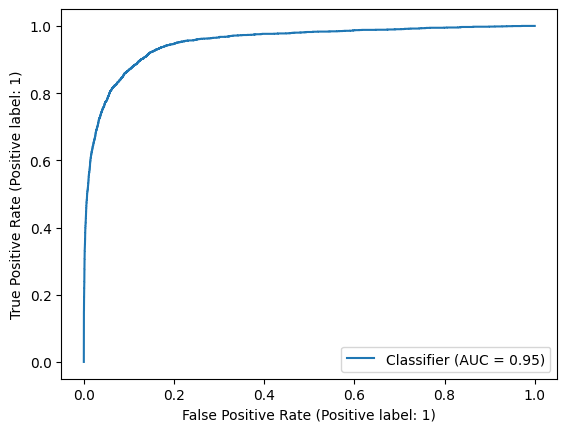

In [53]:
RocCurveDisplay.from_predictions(labels, outputs)

In [55]:
test_audio_files_path = '/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_eval/flac'
test_labels_path = '/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.eval.trl.txt'
test_filename2label = getlabels(test_labels_path)

  0%|          | 0/71237 [00:00<?, ?it/s]

In [58]:
class ASVSpoof1(torch.utils.data.Dataset):
    def __init__(self, audio_dir_path, num_samples, filename2label,transforms1):
        super().__init__()
        self.audio_dir_path = audio_dir_path
        self.num_samples = num_samples
        self.audio_file_names = self.get_audio_file_names(filename2label)
        self.labels, self.label2id, self.id2label = self.get_labels(filename2label)
#         self.transforms = transforms
        self.transforms1 = transforms1
        
    def __getitem__(self, index):
        signal, sr = torchaudio.load(os.path.join(self.audio_dir_path, self.audio_file_names[index]))
#         print(signal.shape)
        signal = self.mix_down_if_necessary(signal)
        signal = self.cut_if_necessary(signal)
#         print(signal.shape)
        signal = self.right_pad_if_necessary(signal)
#         print(signal.shape)
#         signal = self.transforms(signal)
        signal = self.transforms1(signal)
#         print(signal.shape)
        label = (self.labels[index])
        return signal, label
    
    def __len__(self):
        return len(self.labels)
    
    def get_audio_file_names(self, filename2label):
        audio_file_names = list(filename2label.keys())
        audio_file_names = [name + '.flac' for name in audio_file_names] # adding extension
        return audio_file_names
    
    def get_labels(self, filename2label):
        labels = list(filename2label.values())
        id2label = {idx : label for idx, label in  enumerate(list(set(labels)))}
        label2id = {label : idx for idx, label in  enumerate(list(set(labels)))}
        labels = [label2id[label] for label in labels]
        return labels, label2id, id2label
    
    def mix_down_if_necessary(self, signal): #converting from stereo to mono
        if signal.shape[0] > 1: 
            signal = torch.mean(signal, dim = 0, keepdims = True)
        return signal
    
    def cut_if_necessary(self, signal):
        if signal.shape[1] > self.num_samples:
            signal = signal[:, :num_samples]
        return signal
    
    def right_pad_if_necessary(self, signal):
        length = signal.shape[1]
        if self.num_samples > length:
            pad_last_dim = (0, num_samples - length)
            signal = torch.nn.functional.pad(signal, pad_last_dim)
        return signal

In [60]:
test_dataset1 = ASVSpoof1(test_audio_files_path, num_samples, test_filename2label, mel_spectogram)
test_dataset = ASVSpoof(test_audio_files_path, num_samples, test_filename2label,denoise, mel_spectogram)
test_loader1 = torch.utils.data.DataLoader(test_dataset1, shuffle = True, batch_size = 1024)
test_loader = torch.utils.data.DataLoader(test_dataset, shuffle = True, batch_size = 1024)

In [61]:
# Evaluating on val set
model.eval()
outputs = []
labels = []
test_loss = 0.0
with torch.no_grad():
    test_loop = tqdm(enumerate(test_loader), total = len(test_loader))
    for test_batch_idx, (test_images, test_labels) in test_loop:
        test_images = test_images.to(device)
        test_labels = test_labels.to(device).reshape(-1, 1)
        test_labels = test_labels.type(torch.cuda.FloatTensor) #use torch.FloatTensor if on cpu

        test_outputs = model(test_images)
        outputs.append(test_outputs.cpu().numpy())
        labels.append(test_labels.cpu().numpy())
        curr_test_loss = criterion(test_outputs, test_labels)
        test_loss += curr_test_loss.item()
        test_loop.set_postfix(test_loss = curr_test_loss.item())

  0%|          | 0/70 [00:00<?, ?it/s]

In [ ]:
# Evaluating on val set
model.eval()
outputs = []
labels = []
test_loss = 0.0
with torch.no_grad():
    test_loop = tqdm(enumerate(test_loader1), total = len(test_loader1))
    for test_batch_idx, (test_images, test_labels) in test_loop:
        test_images = test_images.to(device)
        test_labels = test_labels.to(device).reshape(-1, 1)
        test_labels = test_labels.type(torch.cuda.FloatTensor) #use torch.FloatTensor if on cpu

        test_outputs = model(test_images)
        outputs.append(test_outputs.cpu().numpy())
        labels.append(test_labels.cpu().numpy())
        curr_test_loss = criterion(test_outputs, test_labels)
        test_loss += curr_test_loss.item()
        test_loop.set_postfix(test_loss = curr_test_loss.item())

In [62]:
labels = np.concatenate(labels)
outputs = np.concatenate(outputs)
print(labels.shape, outputs.shape)

(71237, 1) (71237, 1)


In [63]:
score = roc_auc_score(labels, outputs)
score

0.9272590720088496

In [64]:
def convert_into_whole(outputs):
    new_output = []
    for o in outputs:
        if o > 0.5:
            new_output.append(1)
        else:
            new_output.append(0)
    return new_output

new_outputs = convert_into_whole(outputs)

In [65]:
print(classification_report(labels, new_outputs))

              precision    recall  f1-score   support

         0.0       0.96      0.92      0.94     63882
         1.0       0.52      0.70      0.59      7355

    accuracy                           0.90     71237
   macro avg       0.74      0.81      0.77     71237
weighted avg       0.92      0.90      0.91     71237



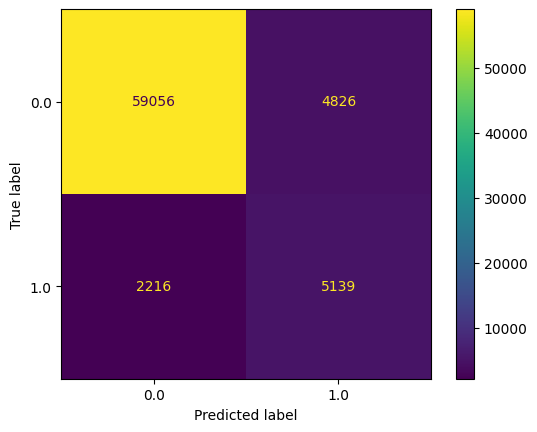

In [66]:
ConfusionMatrixDisplay.from_predictions(labels, new_outputs)

In [67]:
test_dataset.label2id

{'spoof': 0, 'bonafide': 1}

In [68]:
torch.save(model.state_dict(), 'resnet101.pt')

In [69]:
fpr, tpr, threshold = roc_curve(labels, new_outputs, pos_label=1)
fnr = 1 - tpr
eer_threshold = threshold[np.nanargmin(np.absolute((fnr - fpr)))]
eer_threshold

1

In [70]:
EER = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
EER

0.07554553708399862